## OLS Assumption Verification: Endogeneity of regressors

This code is to verify OLS assumption of endogeneity of regressors. Mathematically, this is expressed as the covariance of the error and the Xs is 0 for any error or x. It refers to the prohibition of a link between the independent variables and the errors.

In [1]:
import pandas as pd
from sklearn.datasets import make_regression
import numpy as np
from statistics import stdev
from sklearn.linear_model import LinearRegression

<b>Step 1: Generate Data</b>

In [2]:
random_state = 22

effective_rank = 100

n_sample = 1000 # Number of samples
n_features = 5 # Number of features
n_informative = 5 # Number of features used to build the linear model used to generate the output (i.e. Significant in the output)
n_targets = 1 # Dimension of the y output vector associated with a sample. By default, the output is a scalar
bias = 0.0 # Bias term in the underlying linear model
noise = 0 # Standard deviation of the gaussian noise applied to the output (i.e. Stdev of residuals)

y_column = "Target"

In [3]:
X, y, coef = make_regression(n_samples = n_sample, n_features = n_features,
                             n_informative = n_informative, n_targets = n_targets,
                             noise = noise, coef = True, random_state=random_state,
                             effective_rank = effective_rank)

<b>Step 2: Fit Model</b>

In [4]:
import statsmodels.api as sm

def fit_model(X_input):
    #X_with_constant = sm.add_constant(X_input)
    regressor_OLS = sm.OLS(endog = y, exog = X_input).fit()
    return regressor_OLS

<b>Model Summary</b>

In [5]:
X_with_constant = sm.add_constant(X)
regressor_all = fit_model(X_with_constant)
regressor_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.445e+32
Date:                Wed, 19 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:31:59   Log-Likelihood:                 31903.
No. Observations:                1000   AIC:                        -6.379e+04
Df Residuals:                     994   BIC:                        -6.377e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.469e-18   1.07e-16      0.032      0.974   -2.07e-16    2.14e-16
x1            72.9146   3.39e-15   2.15e+16      0.000      72.915      72.915
x2            51.8442   3.39e-15   1.53e+16      0.000      51.844      51.844
x3            68.2984    3.4e-15   2.01e+16      0.000      68.298      68.298
x4             7.1279   3.39e-15    2.1e+15      0.000       7.128       7.128
x5            36.7204   3.39e-15   1.08e+16      0.000      36.720      36.720
==============================================================================
Omnibus:                        1.221   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.543   Jarque-Bera (JB):                1.276
Skew:                           0.082   Prob(JB):                        0.528
Kurtosis:                       2.938   Cond. No.                         31.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b>Step 3: Calculate residuals</b>

In [6]:
# Convert to dataframe
y = pd.DataFrame(y, columns=[y_column])

regressor_for_all = LinearRegression()
regressor_for_all.fit(X,y)
y_pred= regressor_for_all.predict(X)
# Convert Pandas series to Pandas dataframe
y_pred = pd.DataFrame(data=y_pred.flatten())

# Create output data frame
y_all = pd.DataFrame()
y_all['y_Actual'] = y[y_column]
y_all['y_Predicted'] = y_pred[0]
y_all['y_residual'] = y_all['y_Actual'] - y_all['y_Predicted']

# Create X dataframe and rename all columns
X_all = pd.DataFrame(X)
for i in range(n_features):
    X_all.rename(columns = {i: "x"+str(i+1)}, inplace = True)

<b>Calculate Standard deviation of y_Residual</b>

In [7]:
y_residual_stdev = stdev(y_all['y_residual'])
print(y_residual_stdev)

2.832687092711373e-15


<b>Plot y_Actual vs y_Predicted</b>

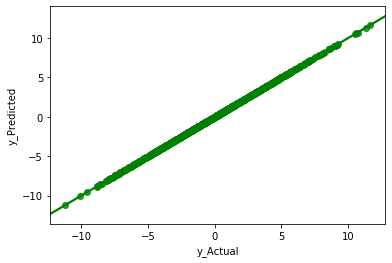

In [9]:
import seaborn as sns
sns.regplot(x="y_Actual", y="y_Predicted", data=y_all, ci=95, color="g")

<b>Calculate VIF for all Xs</b>

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_VIF(input_df):
    VIF_df = pd.DataFrame([variance_inflation_factor(input_df.values, i) 
                   for i in range(input_df.shape[1])],
                  index=input_df.columns)

    if len(VIF_df[VIF_df[0] > 5]) > 0:
        #print("X columns with VIF above 5 are: ", VIF_df[VIF_df[0] > 5].values)
        #message = "There are "+str(len(VIF_df[VIF_df[0] > 5]))+" X-columns with VIF above 5"
        return VIF_df, "There are "+str(len(VIF_df[VIF_df[0] > 5]))+" x-variables with VIF above 5"
    else:
        # print("None of the X columns have VIF higher than 5")
        return VIF_df, ("None of the x-variables have VIF higher than 5")

In [11]:
vif_list, message = calculate_VIF(X_all)
print(message)
print(vif_list)

None of the x-variables have VIF higher than 5
           0
x1  1.000000
x2  1.000003
x3  1.000004
x4  1.000005
x5  1.000007


<b>Step 4:  covariance matrix for all variables with residuals</b>

In [12]:
X_y_all = pd.concat([y_all, X_all], axis=1)
X_y_all.cov().round(4)

,y_Actual,y_Predicted,y_residual,x1,x2,x3,x4,x5
y_Actual,14.0261,14.0261,0.0,0.0729,0.0518,0.0679,0.0068,0.0366
y_Predicted,14.0261,14.0261,0.0,0.0729,0.0518,0.0679,0.0068,0.0366
y_residual,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
x1,0.0729,0.0729,0.0,0.0010,0.0000,0.0000,0.0000,0.0000
x2,0.0518,0.0518,0.0,0.0000,0.0010,0.0000,-0.0000,0.0000
x3,0.0679,0.0679,0.0,0.0000,0.0000,0.0010,-0.0000,-0.0000
x4,0.0068,0.0068,0.0,0.0000,-0.0000,-0.0000,0.0010,-0.0000
x5,0.0366,0.0366,0.0,0.0000,0.0000,-0.0000,-0.0000,0.0010


### <b>Results:</b>
1. R-square and Adjusted R-square is equal to 1
2. VIF for x1 through x5 is almost equal to 1, indicating no multicollinearity
3. Standard deviation of the Gaussian noise = 0
4. Cov(all Xs, Error) is equal to zero
5. All Xs i.e. x1 through x5, are significant as P-value in model summary is almost 0
6. Intercept (constant) is equal to 3.469e-18 and is not significant (P-value is equal to 0.974)

### <b>Conclusion:</b>
As seen in Step 4 Covariance matrix, the covariance of the error and the Xs is 0 and hence we can conclude prohibition of a link between the independent variables and error.